## Import OGER output

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [37]:
%%time

import pandas as pd
import seaborn as sns
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'

Matplotlib is building the font cache; this may take a moment.


CPU times: user 1.68 s, sys: 844 ms, total: 2.53 s
Wall time: 22.6 s


In [4]:
cols = ['BiosampleId', 'Biolink', 'BeginTerm', 'EndTerm', 'TokenizedTerm', 'PreferredTerm', 'CURIE', 'NaN1', 'S-Type', 'NaN2', 'UMLS_CUI']
ogerOutput = pd.read_csv('../output/FullNLPOutput.tsv', sep='\t', names=cols )
ogerOutput = ogerOutput.drop(['NaN1', 'NaN2', 'UMLS_CUI'], axis = 1)
print('Total number of rows: ', str(len(ogerOutput)))
ogerOutput.head()
#pd.set_option("display.max_rows", None)
#print(ogerOutput.CURIE.value_counts())

Total number of rows:  2386121


,BiosampleId,Biolink,BeginTerm,EndTerm,TokenizedTerm,PreferredTerm,CURIE,S-Type
0,SAMN10586215,biolink:OntologyClass,16,24,contains,contains,RO:0001019,S1
1,SAMN10586215,biolink:OrganismalEntity,119,127,Bacteria,Bacteria,NCBITaxon:2,S1
2,SAMN05720810,biolink:OntologyClass,50,57,part of,part of,BFO:0000050,S1
3,SAMN05720810,biolink:OntologyClass,79,90,Agriculture,agricultural process,ENVO:01001246,S1
4,SAMN05720810,biolink:OntologyClass,79,90,Agriculture,animal husbandry,ENVO:01001248,S1


In [5]:
ogerInput = pd.read_csv('../output/biosampleDescriptionDF.tsv', sep='\t')
ogerInput.BiosampleId = ogerInput.BiosampleId.map(lambda x: x.replace('BIOSAMPLE:',''))
ogerInput = ogerInput.drop(['StudyId', 'Name', 'Title'], axis = 1)
print('Number of rows: '+ str(len(ogerInput)))
print('Number of unique Ids: '+ str(len(ogerInput.BiosampleId.unique())))
print('Number of unique Desc: '+ str(len(ogerInput.Description.unique())))
ogerInput = ogerInput.drop_duplicates()
print('******After duplicate row removal*****')
print('Number of rows: '+ str(len(ogerInput)))
print('Number of unique Ids: '+ str(len(ogerInput.BiosampleId.unique())))
print('Number of unique Description: '+ str(len(ogerInput.Description.unique())))
ogerInput.head()

Number of rows: 948401
Number of unique Ids: 938333
Number of unique Desc: 59789
******After duplicate row removal*****
Number of rows: 947374
Number of unique Ids: 938333
Number of unique Description: 59789


,Description,BiosampleId
0,Treponema denticola ATCC 35405. Treponema dent...,SAMN02603967
1,Treponema pallidum subsp. pallidum. This organ...,SAMN02604348
2,Campylobacter fetus subsp. venerealis str. Azu...,SAMN02471365
3,Campylobacter jejuni strain NCTC11168. This st...,SAMEA1705929
4,Francisella tularensis subsp. tularensis strai...,SAMEA3138185


In [6]:
print('Unique BiosampleIds: '+ str(len(ogerOutput.BiosampleId.unique())))
print('Unique CURIEs: '+ str(len(ogerOutput.CURIE.unique())))
print('Unique Biolinks: '+ str(len(ogerOutput.Biolink.unique())))
print('Unique Standard Terms: '+ str(len(ogerOutput.PreferredTerm.unique())))

Unique BiosampleIds: 649677
Unique CURIEs: 1686
Unique Biolinks: 4
Unique Standard Terms: 1677


In [ ]:
curieOfInterest = ['ENVO', 'PATO', 'RO']
envoPato = ogerOutput[ogerOutput.CURIE.str.contains('|'.join(curieOfInterest))]
print('Number of rows: '+ str(len(envoPato)))
envoPato.head()

In [ ]:
salineTerms = ['sali', 'salt']
envPatSal = envoPato[envoPato.TokenizedTerm	.str.contains('|'.join(salineTerms))]
print('Number of rows: '+ str(len(envPatSal)))
envPatSal.head()

In [109]:
# Get list of IDs from structured data file

#fp = '../input/water-related-samples.tsv.gz'
fp = '../input/non-human-samples.tsv.gz'

structuredDataDF = pd.read_csv(fp, sep='\t', low_memory=False)
print('Number of rows: ', str(len(structuredDataDF)))
structuredDataDF.head()

Number of rows:  45951


,tot_diss_nitro,salinity_meth,watering_regm,extreme_event,diss_hydrogen,heavy_metals,microbial_biomass,soil_type,tidal_stage,encoded_traits,...,depth,silicate,sieving,tot_part_carb,trophic_level,calcium,id,taxonomy_id,taxonomy_name,package
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,87.66,BIOSAMPLE:SAMEA1706329,449393,freshwater metagenome,Generic.1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.28,BIOSAMPLE:SAMEA1706311,449393,freshwater metagenome,Generic.1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,87.05,BIOSAMPLE:SAMEA1706320,449393,freshwater metagenome,Generic.1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,126.11,BIOSAMPLE:SAMEA1706300,449393,freshwater metagenome,Generic.1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,332.17,BIOSAMPLE:SAMEA1706316,449393,freshwater metagenome,Generic.1.0


### Get OGER data corresponding to the ones present in structured data

#### From OGER Input

In [111]:
structDataID = structuredDataDF.id.str.replace('BIOSAMPLE:','')
structDataIdDF = pd.DataFrame(structDataID)
structDataOgerInput = ogerInput.merge(structDataIdDF, how='inner', left_on='BiosampleId', right_on='id')
structDataOgerInput = structDataOgerInput.drop(['id'], axis = 1)
print('Number of rows: '+ str(len(structDataOgerInput)))
structDataOgerInput.head()

Number of rows: 515


,Description,BiosampleId
0,Rhodopirellula baltica WH47.\nThis strain was ...,SAMN00713600
1,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228699
2,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228700
3,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228701
4,Purple microbial (Photo- and chemosynthetic) m...,SAMN02228702


#### From OGER output

In [112]:
structDataOgerOutput = ogerOutput.merge(structDataIdDF, how='inner', left_on='BiosampleId', right_on='id')
structDataOgerOutput = structDataOgerOutput.drop(['id'], axis = 1)
print('Number of row: '+ str(len(structDataOgerOutput)))
structDataOgerOutput.head()

Number of row: 4092


,BiosampleId,Biolink,BeginTerm,EndTerm,TokenizedTerm,PreferredTerm,CURIE,S-Type
0,SAMN02393652,biolink:ChemicalSubstance,19,24,probe,probe,CHEBI:50406,S1
1,SAMN02393652,biolink:OntologyClass,61,65,soil,soil,ENVO:00001998,S1
2,SAMN02393652,biolink:AnatomicalEntity,70,73,gut,digestive tract,UBERON:0001555,S1
3,SAMN02393652,biolink:OntologyClass,70,73,gut,watercourse,ENVO:00000029,S1
4,SAMN02393652,biolink:AnatomicalEntity,70,73,gut,digestive system,UBERON:0001007,S1


### Form Phrases for each biosample

Phrase = list of all terms recognized by OGER

In [113]:
%%time
# Function to phrase-ify
def phrasify(dataFrame, columnNames):
    count = 0
    returnDF = pd.DataFrame(columns=columnNames)
    
    bsIdList = dataFrame.BiosampleId.unique()
    
    for i in bsIdList:
        count += 1
        tmpDF = pd.DataFrame()
        bpList = []
        phrase1 = []
        phrase2 = []
        curie = []

        tmpDF = dataFrame.loc[(dataFrame.BiosampleId == i)]
        
        # Filter: Consider ONLY 3 or more DISTINCT terms AND if an RO CURIE is present
        
        #if len(tmpDF) > 2 \
        #and len(tmpDF.TokenizedTerm.unique()) > 2 \
        #and tmpDF.CURIE.str.contains('RO').any():
            
        tmpDF.sort_values(by=['BeginTerm'], inplace=True)

        for row in tmpDF.iterrows():
            bpList.append(row[1].BeginTerm)
            phrase1.append(row[1].TokenizedTerm)
            phrase2.append(row[1].PreferredTerm)
            curie.append(row[1].CURIE)

        returnDF = returnDF.append(pd.DataFrame([[i, bpList, phrase1, phrase2, curie]], columns=columnNames))
            
        if count % 1000 == 0:
            print('Number of relevant rows: '+ str(len(returnDF))+ ' - '+ datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
        # *********** FOR DEBUG PURPOSES ONLY ****************
        #if count == 5000:
        #    break;
        
    return returnDF

CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 16.2 µs


In [114]:
%%time

pCols = ['BiosampleId', 'BeginPosList', 'Phrase', 'StdPhrase', 'CURIE']
phraseDF = phrasify(structDataOgerOutput,pCols)
print('*****Number of rows: '+ str(len(phraseDF)) + ' ********')
phraseDF.head()

*****Number of rows: 486 ********
CPU times: user 2.04 s, sys: 38.3 ms, total: 2.08 s
Wall time: 2.08 s


,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE
0,SAMN02393652,"[19, 61, 70, 70, 70, 208]","[probe, soil, gut, gut, gut, function]","[probe, soil, digestive tract, watercourse, di...","[CHEBI:50406, ENVO:00001998, UBERON:0001555, E..."
0,SAMN02708875,"[57, 65, 69]","[lateral, bay, sediment]","[lateral to, bay, sediment]","[OBO:PATO_0001193, ENVO:00000032, ENVO:00002007]"
0,SAMN02389811,"[20, 48, 179, 189, 202, 202, 221, 221, 241, 25...","[aquarium, mesocosm, part of, flow, system, sy...","[aquarium, mesocosm, part of, mass wasting flo...","[ENVO:00002196, ENVO:01000620, BFO:0000050, EN..."
0,SAMN02251077,"[65, 98, 188, 198, 216, 231, 259, 259, 273, 273]","[bacteria, lagoon, site, temperate, lagoon, fr...","[Bacteria, lagoon, site, temperate, lagoon, fr...","[NCBITaxon:2, ENVO:00000038, BFO:0000029, ENVO..."
0,SAMEA2620360,"[42, 160, 200, 231, 231]","[seawater, Ocean, all, quality, quality]","[sea water, ocean, root, quality, quality]","[ENVO:00002149, ENVO:00000015, NCBITaxon:1, OB..."


In [115]:
# Add prefix 'BIOSAMPLE:' to the id 
phraseDF.BiosampleId = 'BIOSAMPLE:' + phraseDF.BiosampleId
phraseDF.head()

,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE
0,BIOSAMPLE:SAMN02393652,"[19, 61, 70, 70, 70, 208]","[probe, soil, gut, gut, gut, function]","[probe, soil, digestive tract, watercourse, di...","[CHEBI:50406, ENVO:00001998, UBERON:0001555, E..."
0,BIOSAMPLE:SAMN02708875,"[57, 65, 69]","[lateral, bay, sediment]","[lateral to, bay, sediment]","[OBO:PATO_0001193, ENVO:00000032, ENVO:00002007]"
0,BIOSAMPLE:SAMN02389811,"[20, 48, 179, 189, 202, 202, 221, 221, 241, 25...","[aquarium, mesocosm, part of, flow, system, sy...","[aquarium, mesocosm, part of, mass wasting flo...","[ENVO:00002196, ENVO:01000620, BFO:0000050, EN..."
0,BIOSAMPLE:SAMN02251077,"[65, 98, 188, 198, 216, 231, 259, 259, 273, 273]","[bacteria, lagoon, site, temperate, lagoon, fr...","[Bacteria, lagoon, site, temperate, lagoon, fr...","[NCBITaxon:2, ENVO:00000038, BFO:0000029, ENVO..."
0,BIOSAMPLE:SAMEA2620360,"[42, 160, 200, 231, 231]","[seawater, Ocean, all, quality, quality]","[sea water, ocean, root, quality, quality]","[ENVO:00002149, ENVO:00000015, NCBITaxon:1, OB..."


In [116]:
#result = ogerInput.merge(phraseDF, how='inner', on='BiosampleId')
result = structuredDataDF.merge(phraseDF, how='left', left_on='id', right_on='BiosampleId')
print('Number of rows: '+ str(len(result)))
result.head()

Number of rows: 45951


,tot_diss_nitro,salinity_meth,watering_regm,extreme_event,diss_hydrogen,heavy_metals,microbial_biomass,soil_type,tidal_stage,encoded_traits,...,calcium,id,taxonomy_id,taxonomy_name,package,BiosampleId,BeginPosList,Phrase,StdPhrase,CURIE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.66,BIOSAMPLE:SAMEA1706329,449393,freshwater metagenome,Generic.1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.28,BIOSAMPLE:SAMEA1706311,449393,freshwater metagenome,Generic.1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.05,BIOSAMPLE:SAMEA1706320,449393,freshwater metagenome,Generic.1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126.11,BIOSAMPLE:SAMEA1706300,449393,freshwater metagenome,Generic.1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,332.17,BIOSAMPLE:SAMEA1706316,449393,freshwater metagenome,Generic.1.0,NaN,NaN,NaN,NaN,NaN


In [20]:
result.to_csv('../output/waterSampleWithEnitityPhrases.tsv', sep='\t', index=False)

In [117]:
packageVsBiosample = pd.DataFrame(result.BiosampleId).set_index(result.env_package)
counts = packageVsBiosample.groupby(['env_package']).agg(len)
print("Counts regardless of NLP data")
print(counts)

Counts regardless of NLP data
                                    BiosampleId
env_package                                    
Coastal water body (ENVO:02000049)            1
Deep-sea water                                1
MIGS.plant-associated                         3
MIGS/MIMS/MIMARKS.air                       205
MIGS/MIMS/MIMARKS.plant-associated         1063
MIGS/MIMS/MIMARKS.sediment                 1177
MIGS/MIMS/MIMARKS.soil                     3784
MIGS/MIMS/MIMARKS.wastewater                385
MIGS/MIMS/MIMARKS.water                    1763
MIMARKS_water                                 6
Sea water                                     1
Sediment                                      1
Soil                                         19
Water                                         3
air                                         152
fresh water                                  27
freshwater sediment                           9
marine sediment (ENVO:00002113)               1
plant     

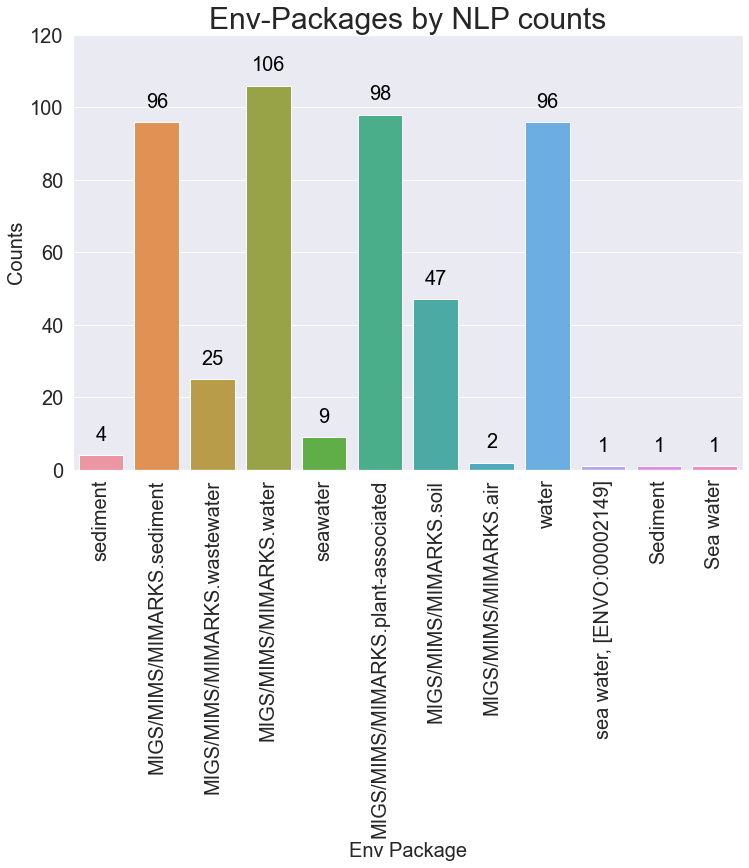

In [118]:
biosamplePackage = result[['BiosampleId', 'env_package']]
biosamplePackage = biosamplePackage.dropna()
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x = biosamplePackage.env_package, data = biosamplePackage)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Env-Packages by NLP counts', fontsize=30)
ax.set_xlabel("Env Package",fontsize=20)
ax.set_ylabel("Counts",fontsize=20)
ax.tick_params(labelsize=20)

#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=20, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations